In [7]:
import pandas as pd
from csgo_wp.data_transform import CSGODataset, transform_multichannel
from csgo_wp.model import LR_CNN
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
import torch
from itertools import permutations

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

test_dataset = CSGODataset(transform=transform_multichannel,
                           dataset_split='test',
                           verbose=False,
                           )

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=64,
                                          shuffle=False,
                                          num_workers=0,
                                          )

device = 'cuda:0'

model = LR_CNN(input_size=(6, 5, 5),
               hidden_sizes=[200, 100, 50],
               activation='LeakyReLU',
               activation_params={},
               dropout=False,
               batch_norm=False,
               cnn_options=((4, 6, 1, 1, 0, 1, 1, 0),
                            (6, 6, 1, 1, 0, 1, 1, 0),
                            (6, 6, 5, 1, 0, 1, 1, 0),),
               )
model.load_state_dict(torch.load('csgo_wp/model-final.pt'))
model.eval();

Reading transformed data...

Done!


In [9]:
model.to(device)

outputs = []

with torch.no_grad():
    for index, (data, target) in enumerate(test_loader):
        model_output = []
        for permutation in permutations([0, 1, 2, 3, 4], r=5):
            # permute the data
            data[:, 0] = data[:, 0, permutation, :]
            data[:, 0] = data[:, 0, :, permutation]

            data[:, 2] = data[:, 2, permutation, :]
            data[:, 3] = data[:, 3, :, permutation]

            data[:, 4] = data[:, 4, permutation, :]
            data[:, 4] = data[:, 4, :, permutation]

            # get the model output
            data = data.to(device)
            output = model(data)
            model_output.append(output)
        outputs.append(model_output)

In [29]:
stds = []

for perm in outputs:
    permutation_results = pd.DataFrame([x.detach().cpu().numpy() for x in perm]).T
    stds.append(permutation_results.std(axis=1))
    
stds = pd.concat(stds, axis=0)
stds.head()

0    0.010496
1    0.009052
2    0.004919
3    0.003570
4    0.003872
dtype: float64

Text(0, 0.5, 'Incidence')

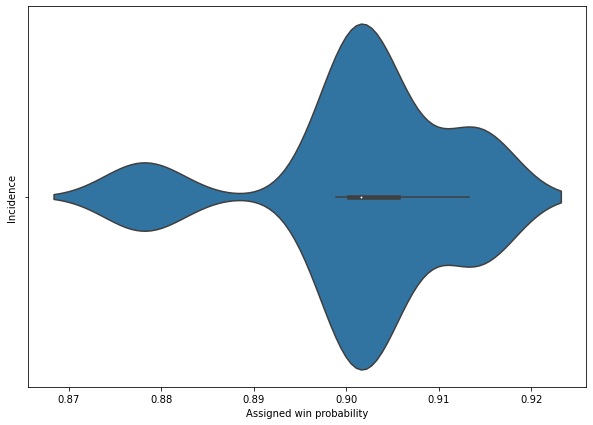

In [54]:
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.violinplot(permutation_results.iloc[15])
plt.xlabel('Assigned win probability')
plt.ylabel('Incidence')

In [51]:
permutation_results.iloc[15].std()

0.010396631729692322

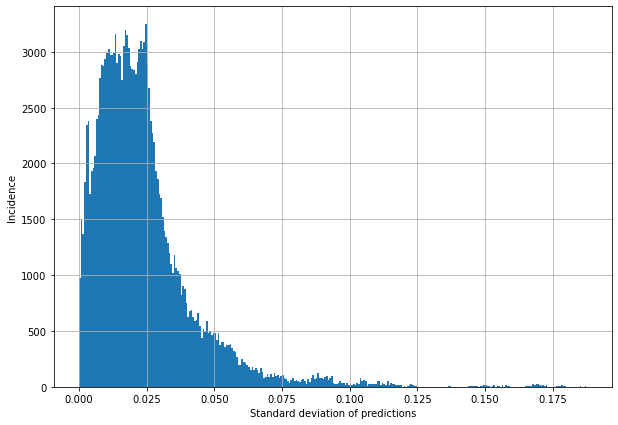

In [38]:
plt.figure(figsize=(10, 7))
stds.hist(bins=300)
plt.xlabel('Standard deviation of predictions')
plt.ylabel('Incidence');